## Kaggle "News Category" Dataset

### (For Colab) Mount Drive, check environment, and install packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Check GPU
!nvidia-smi

Fri May  8 00:45:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-thm328qv
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-thm328qv
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=e8c82b68567138fb8ee2e03317cb7870f467a088449404832fa0421bbf9e3a57
  Stored in directory: /tmp/pip-ephem-wheel-cache-hfe_dxht/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
     |████████████████████████████████| 711.0MB 13kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
# Verify MXNet detects GPU
import d2l
d2l.try_all_gpus()

# Should say [gpu(0)], NOT [cpu(0)]

[gpu(0)]

### Load data and encode labels

In [0]:
import pandas as pd
import numpy

# For local use
# newscat_raw = pd.read_json("./news-category-dataset/News_Category_Dataset_v2.json", lines = True)

# For Colab
newscat_raw = pd.read_json("/content/drive/My Drive/news-category-dataset/News_Category_Dataset_v2.json", lines = True)

newscat_raw.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [0]:
len(newscat_raw)

200853

In [0]:
# We have over 200k examples.
pd.value_counts(newscat_raw['category'])


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

There are 41 categories here, with as few as 1,004 examples (EDUCATION) and as many as 32,739 (POLITICS).

One oddity is that we have "WORLDPOST" and "THE WORLDPOST". It seems like this should be one combined category.

In [0]:
newscat_raw['category'] = newscat_raw['category'].str.replace("THE WORLDPOST", "WORLDPOST")
pd.value_counts(newscat_raw['category'])

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, dtype: int64

Now that we have combined "THE WORLDPOST" and "WORLDPOST" into a single category, we have 40 total categories. It's still not clear how, for example, WORLDPOST is different from WORLD NEWS.

In [0]:
# Check for missing values
newscat_raw.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [0]:
# This dataset is nice and clean! No null values to worry about!
# We have a headline, an author, and a short description to work with. Let's bring them all into one descriptor column

newscat_raw['full_description'] = newscat_raw[['authors','headline','short_description']].agg(' '.join, axis = 1)

# Maybe we shouldn't use the author (after discussion we will leave it in)
# newscat_raw['full_description'] = newscat_raw[['headline','short_description']].agg(' '.join, axis = 1)

newscat_raw.head()

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Ron Dicker Julianna Margulies Uses Donald Trum...


In [0]:
# Let's remove the stopwords from our data
# We'll use the stopwords list from the nltk corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Convert to string
newscat_raw['full_description'] = newscat_raw['full_description'].astype("string")

# Remove special characters
newscat_raw['full_description'] = newscat_raw['full_description'].str.replace(r'[^\w\s]+','') # Had to read up on Regex, but this finally got rid of punctuation! -JC

# Convert to lower, tokenize, and remove stop words
newscat_raw['full_description'] = newscat_raw['full_description'].str.lower().str.split()
newscat_raw['full_description'] = newscat_raw['full_description'].apply(lambda x: [item for item in x if item not in stop])
newscat_raw.head(10)

,category,headline,authors,link,short_description,date,full_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,"[melissa, jeltsen, 2, mass, shootings, texas, ..."
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,"[andy, mcdonald, smith, joins, diplo, nicky, j..."
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,"[ron, dicker, hugh, grant, marries, first, tim..."
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,"[ron, dicker, jim, carrey, blasts, castrato, a..."
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,"[ron, dicker, julianna, margulies, uses, donal..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,"[ron, dicker, morgan, freeman, devastated, sex..."
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26,"[ron, dicker, donald, trump, lovin, new, mcdon..."
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26,"[todd, van, luling, watch, amazon, prime, that..."
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26,"[andy, mcdonald, mike, myers, reveals, hed, li..."
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26,"[todd, van, luling, watch, hulu, thats, new, w..."


(array([1.8480e+03, 1.7310e+04, 3.3858e+04, 5.2089e+04, 3.6183e+04,
        2.4527e+04, 1.5891e+04, 1.1609e+04, 5.3040e+03, 1.4040e+03,
        4.7700e+02, 1.0200e+02, 3.4000e+01, 2.7000e+01, 7.0000e+00,
        1.3000e+01, 2.4000e+01, 3.4000e+01, 3.2000e+01, 1.9000e+01,
        2.9000e+01, 1.0000e+01, 7.0000e+00, 6.0000e+00, 2.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,   5.8,  10.6,  15.4,  20.2,  25. ,  29.8,  34.6,  39.4,
         44.2,  49. ,  53.8,  58.6,  63.4,  68.2,  73. ,  77.8,  82.6,
         87.4,  92.2,  97. , 101.8, 106.6, 111.4, 116.2, 121. , 125.8,
        130.6, 135.4, 140.2, 145. ]),
 <a list of 30 Patch objects>)

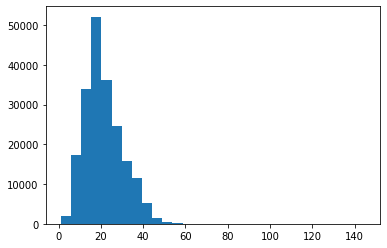

In [0]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(newscat_raw['full_description'].apply(len), bins=30)

We see here that if we fix our examples at 50 tokens, it will capture the vast majority of our examples in full.

In [0]:
# Now convert our text categories to panda categories for conversion to numeric labels
labels_raw = newscat_raw["category"].astype('category')
labels_raw["category"] = newscat_raw["category"].astype('category')
labels_raw.head()

0            CRIME
1    ENTERTAINMENT
2    ENTERTAINMENT
3    ENTERTAINMENT
4    ENTERTAINMENT
Name: category, dtype: object

In [0]:
labels_raw['catnum'] = labels_raw["category"].cat.codes
labels_raw['catnum']

0          6
1         10
2         10
3         10
4         10
          ..
200848    32
200849    28
200850    28
200851    28
200852    28
Length: 200853, dtype: int8

Create dictionary for going back and forth between codes and category names

In [0]:
category_dict = dict(enumerate(labels_raw["category"].cat.categories))
category_dict

{0: 'ARTS',
 1: 'ARTS & CULTURE',
 2: 'BLACK VOICES',
 3: 'BUSINESS',
 4: 'COLLEGE',
 5: 'COMEDY',
 6: 'CRIME',
 7: 'CULTURE & ARTS',
 8: 'DIVORCE',
 9: 'EDUCATION',
 10: 'ENTERTAINMENT',
 11: 'ENVIRONMENT',
 12: 'FIFTY',
 13: 'FOOD & DRINK',
 14: 'GOOD NEWS',
 15: 'GREEN',
 16: 'HEALTHY LIVING',
 17: 'HOME & LIVING',
 18: 'IMPACT',
 19: 'LATINO VOICES',
 20: 'MEDIA',
 21: 'MONEY',
 22: 'PARENTING',
 23: 'PARENTS',
 24: 'POLITICS',
 25: 'QUEER VOICES',
 26: 'RELIGION',
 27: 'SCIENCE',
 28: 'SPORTS',
 29: 'STYLE',
 30: 'STYLE & BEAUTY',
 31: 'TASTE',
 32: 'TECH',
 33: 'TRAVEL',
 34: 'WEDDINGS',
 35: 'WEIRD NEWS',
 36: 'WELLNESS',
 37: 'WOMEN',
 38: 'WORLD NEWS',
 39: 'WORLDPOST'}

### Final Model: Partition into train and test
Now that we've selected our best model, we will train on the combined train and validation data and finally test on the data we've held out until now.

In [0]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import numpy
import random
npx.set_np()

In [0]:
# Partition into training and test
train_pct = .9
# Test set will be remainder of examples

num_examples = len(labels_raw['catnum'])
rownums = list(range(num_examples))

random.seed(1729) # Set seed so test data doesn't leak across multiple sessions.
random.shuffle(rownums)
# Since this ordering is consistant, we will have the same 10% of test rows held out that we held out during training.


train_examples = int(num_examples * train_pct)

trainsetnums = rownums[:train_examples]
testsetnums = rownums[train_examples: ]

print("Train/Validate/Test count: ", len(trainsetnums), len(testsetnums))

Train/Validate/Test count:  180767 20086


In [0]:
Examples_train = list(newscat_raw['full_description'][trainsetnums])
Examples_test = list(newscat_raw['full_description'][testsetnums])

train_labels = list(labels_raw['catnum'][trainsetnums])
test_labels = list(labels_raw['catnum'][testsetnums])

In [0]:
y_train = np.array(labels_raw['catnum'][trainsetnums], dtype = np.float32).reshape(-1, 1)
y_test = np.array(labels_raw['catnum'][testsetnums], dtype = np.float32).reshape(-1, 1)

print(y_train.shape, len(Examples_train))
print(y_test.shape, len(Examples_test))

(180767, 1) 180767
(20086, 1) 20086


In [0]:

### We changed our text preprocessing so our examples are already split into words above.

train_tokens = Examples_train
test_tokens = Examples_test

Let's look at some random examples from the training data to see if our headlines and categories make sense.

In [0]:
example_num = random.randint(0,len(trainsetnums))
print(train_tokens[example_num])
print(category_dict.get(int(y_train[example_num])))

['regina', 'weinreich', 'contributor', 'author', 'kerouacs', 'spontaneous', 'poetics', 'revisiting', 'crime', 'scene', 'west', 'memphis', 'paradise', 'lost', 'trilogy', 'peter', 'jacksons', 'hobbit', 'isnt', 'film', 'director', 'opening', 'west', 'memphis', 'documentary', 'partner', 'fran', 'walsh', 'produced', 'revisits', 'murder', 'three', '8yearolds', '1993', 'three', 'teens', 'went', 'jail', 'crime']
ENTERTAINMENT


### Word Embeddings

We'll use the `Vocab` function defined in D2L 8.2.

In [0]:
# TODO(JC): I'm trying to avoid calling the d2l package directly, but I'm having a hard time  
#           adapting the Vocab function from the version defined in d2l 8.2.
#           UPDATE: Given time constraints, let's just keep the d2l function here. 

import d2l
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>']) 

In [0]:
print(vocab.token_freqs[:20]) # Check the most frequent words. Stop words and special characters have been removed.


[('contributor', 34307), ('new', 17897), ('one', 14272), ('us', 13616), ('trump', 12112), ('time', 10919), ('people', 10875), ('like', 10489), ('author', 10287), ('photos', 10153), ('day', 9469), ('life', 8913), ('get', 8547), ('make', 8220), ('world', 7571), ('first', 7353), ('writer', 7132), ('dont', 7129), ('best', 6857), ('years', 6781)]


In [0]:
# Load pre-trained GloVe word embedding. This is available as a resource in mxnet. 
# We'll follow d2l's lead and use the 100d version
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

# Check the dimentions of our embeddings (should be vocab size x dimensionality of embedding we chose)
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(39417, 100)

### Data iterator

In [0]:
num_steps = 50  # Sequence length. We saw above that 50 should be plenty.
train_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

test_features = np.array([d2l.truncate_pad(  ###JC: Another invocation of d2l library
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
print(test_features.shape)


(180767, 50)
(20086, 50)


In [0]:
X_train = np.array(train_features, dtype = np.float32)
X_test = np.array(test_features, dtype = np.float32)

In [0]:
batch_size = 128
train_iter = d2l.load_array((train_features, train_labels), batch_size)   
test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)   


for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (128, 50) y (128,)


('# batches:', 1413)

### Training Loop

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, batch_size, ctx=d2l.try_gpu()):
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  train_ls, train_acc, test_acc = [], [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)
  trainer = gluon.Trainer(net.collect_params(),
                              'adam', {'learning_rate': lr})
  
  for epoch in range(num_epochs):
    train_acc_minibatch = []
    train_ls_minibatch = []
    test_acc_minibatch = []
    for i, (X, y) in enumerate(train_iter):
      X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat, y)
      l.backward()
      # print("Minibatch Completed")
      if(len(y) == batch_size): # Only calculate on full minibatches
        train_accuracy = (net(X).argmax(axis = 1).reshape(-1, 1) == 
                          y).sum()/len(y)
        train_loss = loss(net(X), y).mean()
        train_acc_minibatch.append(train_accuracy)
        train_ls_minibatch.append(train_loss)
      # print(train_accuracy)
      trainer.step(batch_size)

    # Validation set is too large to evaluate all at once.
    # Loop to evaluate test accuracy in minibatches.
    for i, (Xtest, ytest) in enumerate(test_iter):
      Xtest, ytest = Xtest.as_in_ctx(ctx), ytest.as_in_ctx(ctx)
      if(len(ytest) == batch_size): # Only calculate on full minibatches
        test_accuracy = (net(Xtest).argmax(axis = 1).reshape(-1, 1) == 
                          ytest).sum()/len(ytest)
        test_acc_minibatch.append(test_accuracy)


    train_acc.append(np.array(train_acc_minibatch).mean())
    test_acc.append(np.array(test_acc_minibatch).mean())
    train_ls.append(np.array(train_ls_minibatch).mean())
    print("Epoch = %d: Train acc: %f, Test acc: = %f" % (epoch, train_acc[-1], test_acc[-1]))
  return train_ls, train_acc, test_acc

### Bi-LSTM with Avg Pooling Layer

The final model we selected during validation

In [0]:
class AvgPoolBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(AvgPoolBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.avgpool = nn.AvgPool1D(pool_size = 5, strides = 5, layout = 'NCW')
        self.decoder = nn.Dense(40)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        hidden_1 = self.avgpool(outputs)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        outs = self.decoder(hidden_1)
        return outs

In [0]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = AvgPoolBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

# embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
# embeds.shape

Epoch = 0: Train acc: 0.680374, Test acc: = 0.744391
Epoch = 1: Train acc: 0.760584, Test acc: = 0.752804
Epoch = 2: Train acc: 0.776707, Test acc: = 0.753305
Epoch = 3: Train acc: 0.786783, Test acc: = 0.754457
Epoch = 4: Train acc: 0.794518, Test acc: = 0.754407
Epoch = 5: Train acc: 0.802037, Test acc: = 0.750952
Epoch = 6: Train acc: 0.809081, Test acc: = 0.752654
Epoch = 7: Train acc: 0.815078, Test acc: = 0.753606
Epoch = 8: Train acc: 0.819173, Test acc: = 0.752704
Epoch = 9: Train acc: 0.822487, Test acc: = 0.750651
Training time 480.77059 sec
Training loss: 0.578181
Train accuracy: 0.822487
Test accuracy: 0.750651


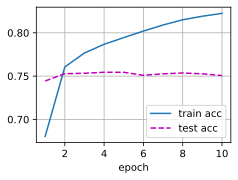

In [0]:
lr, num_epochs, batch_size = 0.01, 10, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_test, y_test, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'test acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Test accuracy: %f" % test_acc[-1])

In [0]:
# Look at random test examples, their actual categories, and their predicted categories

example_num = random.randint(0,len(test_labels))
pred_example = np.array(test_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(test_tokens[example_num])
print("Actual: ", category_dict.get(int(y_test[example_num])))
print("Predicted: ", pred_cat)

['jj', 'virgin', 'contributor', 'celebrity', 'nutrition', 'fitness', 'mindset', 'expert', '12', 'golden', 'rules', 'fast', 'lasting', 'fat', 'loss', 'dont', 'bring', 'enemy', 'means', 'anywhere', 'kitchen', 'glove', 'compartment', 'restaurant', 'table', 'create', 'slippery', 'slope', 'im', 'talking', 'pint', 'butter', 'pecan', 'also', 'potentially', 'dangerous', 'healthy', 'foods', 'like', 'almond', 'butter', 'one', 'tablespoon', 'becomes', 'whole', 'container', 'step', 'away', 'jar']
Actual:  WELLNESS
Predicted:  WELLNESS


### Model Predictions
Let's take a closer look at the predictions being made by our final model.

In [0]:
# Store predictions in a list.
# There's not enough memory to run them all back through the network at once.
# We could use minibatches, but a loop will be fast enough.
predictions = []
for i in range(len(test_labels)):
  pred_example = np.array(test_features[i].reshape(1, -1), ctx=d2l.try_gpu())
  predictions.append(int(np.argmax(net(pred_example))))

In [0]:
prediction_table = pd.DataFrame(predictions, columns = ['CatNum'])
prediction_table['ActCatNum'] = test_labels
prediction_table['PredCategory'] = prediction_table['CatNum'].apply(lambda x: category_dict.get(x))
prediction_table['ActualCategory'] = prediction_table['ActCatNum'].apply(lambda x: category_dict.get(x))
prediction_table['Pred-Actual'] = prediction_table[['ActualCategory', 'PredCategory']].agg('-'.join, axis = 1)

prediction_table.head()

,CatNum,ActCatNum,PredCategory,ActualCategory,Pred-Actual
0,10,10,ENTERTAINMENT,ENTERTAINMENT,ENTERTAINMENT-ENTERTAINMENT
1,34,34,WEDDINGS,WEDDINGS,WEDDINGS-WEDDINGS
2,6,6,CRIME,CRIME,CRIME-CRIME
3,39,39,WORLDPOST,WORLDPOST,WORLDPOST-WORLDPOST
4,3,3,BUSINESS,BUSINESS,BUSINESS-BUSINESS


In [0]:
# Look at the most common pairs of Actual-Predicted where predictions were wrong
pred_incorrect = prediction_table[prediction_table['PredCategory'] != prediction_table['ActualCategory']]
pd.value_counts(pred_incorrect['Pred-Actual']).head(20)

WORLD NEWS-WORLDPOST          79
WORLDPOST-POLITICS            76
ENTERTAINMENT-COMEDY          76
PARENTING-WELLNESS            69
POLITICS-WORLDPOST            67
WELLNESS-PARENTING            62
MEDIA-POLITICS                61
BUSINESS-POLITICS             52
BLACK VOICES-POLITICS         49
BLACK VOICES-ENTERTAINMENT    49
WORLDPOST-WORLD NEWS          48
POLITICS-BUSINESS             46
COMEDY-ENTERTAINMENT          44
GREEN-POLITICS                43
ENTERTAINMENT-POLITICS        41
WOMEN-POLITICS                35
QUEER VOICES-POLITICS         35
POLITICS-CRIME                33
CRIME-POLITICS                33
RELIGION-POLITICS             33
Name: Pred-Actual, dtype: int64

Most of these most common pairs on incorrect labels make some sense. "world news" and "world post" seem like they would be quite similar, as might be "entertainment" and "comedy."

In [0]:
# Export predictions
prediction_table.to_csv('/content/drive/My Drive/model_test_predictions.csv')

In [0]:
# Export the test partition so predictions can be further explored
testdata_export = newscat_raw.iloc[testsetnums]
testdata_export.to_csv('/content/drive/My Drive/newscat_test_data.csv')

### Predictions on scraped data

Now we import the scraped dataset to see how our model classifies these new examples.

In [0]:
scraped_raw = pd.read_csv("/content/drive/My Drive/scraped_news/scraped_data.csv")
scraped_raw.head()

,headline,article,date,category
0,From Loss Of Smell To 'COVID Toes': What Exper...,It's not just a fever and dry cough. For milde...,5/6/2020,Goats and Soda
1,"As Businesses Reopen, A Fight Is Brewing Over ...",Republican Senate Leader Mitch McConnell insis...,5/6/2020,Coronavirus Live Updates
2,"Michigan Legislature Sues Gov. Whitmer, Seekin...",The legislators say the governor is acting ill...,5/6/2020,Coronavirus Live Updates
3,The Risk Of Coronavirus In Afghanistan's Priso...,The Taliban accuse the government of spreading...,5/6/2020,Coronavirus Live Updates
4,Officials Investigating Multiple COVID-19 Deat...,Multiple investigations are underway at the So...,5/6/2020,Coronavirus Live Updates


If the category "Goats and Soda" doesn't get you excited, I don't know what will.

We're not actually using these categories for training, but I regret that this wasn't part of our original dataset.

In [0]:
scraped_raw['full_description'] = scraped_raw[['headline','article']].agg(' '.join, axis = 1)

# Convert to string
scraped_raw['full_description'] = scraped_raw['full_description'].astype("string")

# Remove special characters
scraped_raw['full_description'] = scraped_raw['full_description'].str.replace(r'[^\w\s]+','') # Had to read up on Regex, but this finally got rid of punctuation! -JC

# Convert to lower, tokenize, and remove stop words
scraped_raw['full_description'] = scraped_raw['full_description'].str.lower().str.split()
scraped_raw['full_description'] = scraped_raw['full_description'].apply(lambda x: [item for item in x if item not in stop])
scraped_raw.head(10)


,headline,article,date,category,full_description
0,From Loss Of Smell To 'COVID Toes': What Exper...,It's not just a fever and dry cough. For milde...,5/6/2020,Goats and Soda,"[loss, smell, covid, toes, experts, learning, ..."
1,"As Businesses Reopen, A Fight Is Brewing Over ...",Republican Senate Leader Mitch McConnell insis...,5/6/2020,Coronavirus Live Updates,"[businesses, reopen, fight, brewing, worker, s..."
2,"Michigan Legislature Sues Gov. Whitmer, Seekin...",The legislators say the governor is acting ill...,5/6/2020,Coronavirus Live Updates,"[michigan, legislature, sues, gov, whitmer, se..."
3,The Risk Of Coronavirus In Afghanistan's Priso...,The Taliban accuse the government of spreading...,5/6/2020,Coronavirus Live Updates,"[risk, coronavirus, afghanistans, prisons, com..."
4,Officials Investigating Multiple COVID-19 Deat...,Multiple investigations are underway at the So...,5/6/2020,Coronavirus Live Updates,"[officials, investigating, multiple, covid19, ..."
5,An 11-Year-Old Girl Writes To Thank Her Mailma...,"Emerson Weber, a 5th grader in South Dakota, w...",5/6/2020,Coronavirus Live Updates,"[11yearold, girl, writes, thank, mailman, post..."
6,Everyone Wants What He Makes At The Always Bus...,"The plant in Mehoopany, Pa., which makes Charm...",5/6/2020,Faces Of The Coronavirus Recession,"[everyone, wants, makes, always, busy, charmin..."
7,What Hamburg's Missteps In 1892 Cholera Outbre...,"Lesson No. 1: Have ""proper precautions in plac...",5/6/2020,The Coronavirus Crisis,"[hamburgs, missteps, 1892, cholera, outbreak, ..."
8,20.2 Million Private-Sector Jobs Are Gone,The record job losses are a preview of the Lab...,5/6/2020,Coronavirus Live Updates,"[202, million, privatesector, jobs, gone, reco..."
9,"EU Faces 'Recession Of Historic Proportions,' ...",The response to the COVID-19 pandemic lopped o...,5/6/2020,Coronavirus Live Updates,"[eu, faces, recession, historic, proportions, ..."


(array([2.000e+00, 1.800e+01, 1.500e+01, 8.700e+01, 2.580e+02, 2.070e+02,
        8.320e+02, 1.549e+03, 1.217e+03, 3.634e+03, 5.434e+03, 3.030e+03,
        5.505e+03, 3.255e+03, 7.730e+02, 6.970e+02, 2.030e+02, 5.000e+01,
        7.000e+01, 6.000e+01, 1.900e+01, 3.600e+01, 2.100e+01, 3.000e+00,
        1.200e+01, 5.000e+00, 2.000e+00, 7.000e+00, 1.000e+00, 3.000e+00]),
 array([ 7.        ,  8.66666667, 10.33333333, 12.        , 13.66666667,
        15.33333333, 17.        , 18.66666667, 20.33333333, 22.        ,
        23.66666667, 25.33333333, 27.        , 28.66666667, 30.33333333,
        32.        , 33.66666667, 35.33333333, 37.        , 38.66666667,
        40.33333333, 42.        , 43.66666667, 45.33333333, 47.        ,
        48.66666667, 50.33333333, 52.        , 53.66666667, 55.33333333,
        57.        ]),
 <a list of 30 Patch objects>)

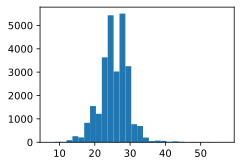

In [0]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(scraped_raw['full_description'].apply(len), bins=30)

In [0]:
# Our 50 token length looks like it is still plenty

scraped_tokens = list(scraped_raw['full_description'])

scraped_features = np.array([d2l.truncate_pad( 
    vocab[line], num_steps, vocab['<pad>']) for line in scraped_tokens])
print(scraped_features.shape)


(27005, 50)


In [0]:
# Store predictions in a list.
# There's not enough memory to run them all back through the network at once.
# We could use minibatches, but a loop will be fast enough.
predictions_scrape = []
for i in range(len(scraped_features)):
  pred_example = np.array(scraped_features[i].reshape(1, -1), ctx=d2l.try_gpu())
  predictions_scrape.append(int(np.argmax(net(pred_example))))

In [0]:
len(predictions_scrape)


27005

In [0]:
pred_scraped_table = pd.DataFrame(predictions_scrape, columns = ['CatNum'])
pred_scraped_table['PredCategory'] = pred_scraped_table['CatNum'].apply(lambda x: category_dict.get(x))

pred_scraped_table.head()

,CatNum,PredCategory
0,36,WELLNESS
1,24,POLITICS
2,24,POLITICS
3,39,WORLDPOST
4,6,CRIME


In [0]:
pred_scraped_table.tail()

,CatNum,PredCategory
27000,33,TRAVEL
27001,24,POLITICS
27002,5,COMEDY
27003,38,WORLD NEWS
27004,36,WELLNESS


In [0]:
# Let's look at the frequency with which it predicted each category
pd.value_counts(pred_scraped_table['PredCategory'])

POLITICS          8903
WORLDPOST         3629
WELLNESS          2378
BUSINESS          1412
CRIME             1135
SPORTS             750
GREEN              725
PARENTING          725
ENTERTAINMENT      666
TRAVEL             655
SCIENCE            594
WORLD NEWS         574
ENVIRONMENT        562
BLACK VOICES       510
IMPACT             505
MEDIA              418
TECH               344
RELIGION           318
QUEER VOICES       270
HEALTHY LIVING     226
WOMEN              194
FOOD & DRINK       163
COLLEGE            157
MONEY              137
LATINO VOICES      137
STYLE & BEAUTY     136
EDUCATION          117
COMEDY             104
WEDDINGS            84
ARTS                79
TASTE               79
CULTURE & ARTS      78
HOME & LIVING       57
DIVORCE             44
ARTS & CULTURE      35
WEIRD NEWS          33
PARENTS             32
GOOD NEWS           16
STYLE               14
FIFTY               10
Name: PredCategory, dtype: int64

Finally, let's randomly look at some of these predictions and see if we subjectively think they make sense.

In [0]:
example_num = random.randint(0,len(scraped_features))
pred_example = np.array(scraped_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(scraped_tokens[example_num])
print("Predicted: ", pred_cat)

['edible', 'archives', 'project', 'aims', 'revive', 'hundreds', 'vanishing', 'indian', 'rice', 'strains', 'hybrid', 'varieties', 'gained', 'popularity', 'hundreds', 'indigenous', 'strains', 'rice', 'knowledge', 'disappeared', 'chefs', 'farmers', 'researchers', 'trying', 'reconnect', 'heritage']
Predicted:  POLITICS


The examples seen so far look pretty reasonable. While this is only a cursory look, it would seem that this model does generalize reasonably to unseen data.

In [0]:
# Export predictions for further exploration
pred_scraped_table.to_csv('/content/drive/My Drive/scraped_news/scraped_predictions.csv')